In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

# For optional type hints.
from torch import Tensor

plt.rc('font', size=15)

## What is PyTorch?

A Python framework for automatic differentiation that provides a large number of tools (optimizers, model architectures) to build and train neural nets.

## Data

### Generation

We generate data with $y=\frac{sin(0.04x^2)}{x + 0.1} + (x / 1000)^{0.5} + \mathcal{N}(0, 0.02)$

### Data pipeline

We need a data pipeline that allows us to extract samples and cobine them to batches. We do this with the `Dataset` class.

In [29]:
class Data(Dataset):
    """Data class definition.
    """
    def __init__(self, num_samples: int=1000, with_error: bool=True) -> None:
        super().__init__()

        self.num_samples = num_samples
        self.with_error = with_error

        self.x = np.random.uniform(0., 100., size=(num_samples, 1)).astype('float32')

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, ind: int) -> np.ndarray:
        x = self.x[ind]
        y = self.datagen(x)

        return x.astype('float32'), y.astype('float32')

    @staticmethod
    def datagen(x, with_error: bool = True):
        y = np.sin(x * 0.2) ** 2 * (1 / (x + 0.1)) + np.sqrt(x / 1000)
        if with_error:
             y += np.random.normal(0.0, 0.02, size=len(x))
        return y

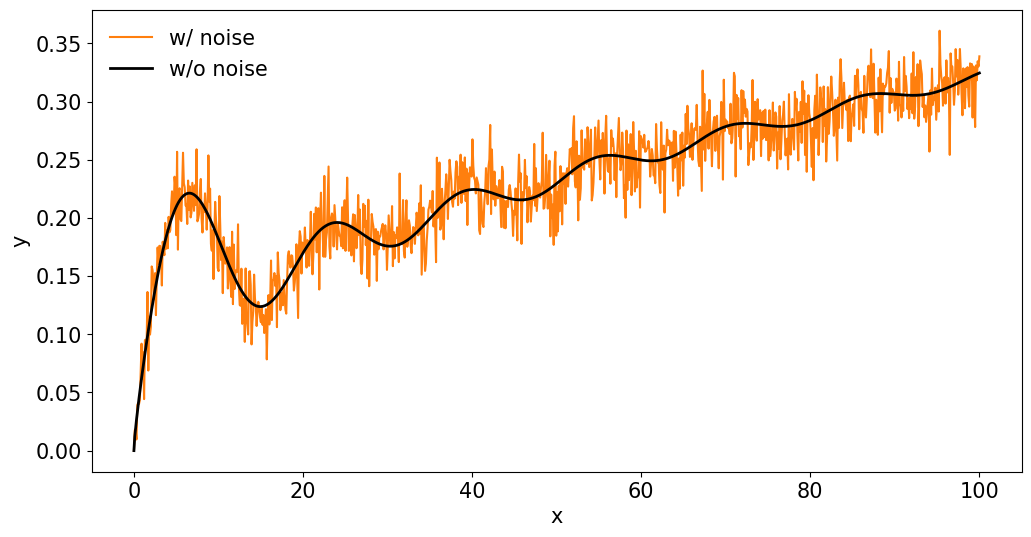

In [30]:
x = np.linspace(0, 100, 1000)
plt.figure(figsize=(12, 6))
plt.plot(x, Data.datagen(x, with_error=True), label='w/ noise', color='tab:orange')
plt.plot(x, Data.datagen(x, with_error=False), label='w/o noise', lw=2, color='k')
plt.legend(frameon=False)
plt.ylabel('y')
plt.xlabel('x')
None

In [31]:
data = Data()

In [32]:
data[2]  # same as data.__getitem__(5)

(array([37.839603], dtype=float32), array([0.22392444], dtype=float32))

In [45]:
dataloader = DataLoader(data, batch_size=10, shuffle=True)

In [46]:
for i, (x, y) in enumerate(dataloader):
    print(f'Batch {i} | x shape: {x.shape}, y shape {y.shape}')
    if i == 5:
        break

Batch 0 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])
Batch 1 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])
Batch 2 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])
Batch 3 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])
Batch 4 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])
Batch 5 | x shape: torch.Size([10, 1]), y shape torch.Size([10, 1])


In [47]:
class Linear(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Linear layer: y = x * w + b
        self.layer = torch.nn.Linear(in_features=1, out_features=1)

    def forward(self, x: Tensor) -> Tensor:

        out = self.layer(x)

        return out

In [48]:
linear_model = Linear()
linear_model

Linear(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)

In [49]:
linear_model(x)

tensor([[ 7.6042],
        [11.4883],
        [ 0.8482],
        [-0.7304],
        [ 0.3658],
        [11.4166],
        [ 2.6881],
        [ 9.8263],
        [ 3.1606],
        [-0.1093]], grad_fn=<AddmmBackward0>)

In [50]:
optimizer = torch.optim.AdamW(linear_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [51]:
num_epochs = 200
losses = np.zeros(num_epochs * len(dataloader)) * np.nan

i = 0
for epoch in tqdm(range(num_epochs), desc='training epoch'):
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = linear_model(x)
        loss = loss_fn(y_hat, y)

        loss.backward()
        optimizer.step()

        losses[i] = loss.detach()
        i += 1

training epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.98it/s]


In [52]:
linear_model.layer.weight.grad

tensor([[2.7316]])

In [53]:
linear_model.layer.weight

Parameter containing:
tensor([[0.0017]], requires_grad=True)

Text(0, 0.5, 'MSE loss')

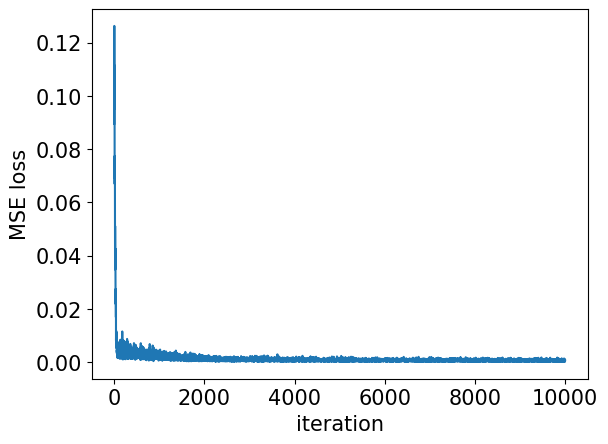

In [65]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')

In [66]:
x = torch.linspace(0, 100, 1000)
y = Data.datagen(x, with_error=False)
y_hat = linear_model(x.unsqueeze(-1)).detach()

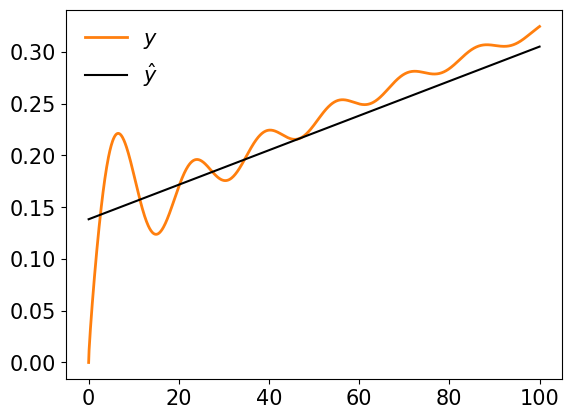

In [67]:
plt.plot(x, y, color='tab:orange', lw=2, label=r'$y$')
plt.plot(x, y_hat, color='k', label=r'$\hat{y}$')
plt.legend(frameon=False)

In [68]:
class NN(torch.nn.Module):
    def __init__(self, num_hidden: int):
        super().__init__()

        self.layer0 = torch.nn.Linear(in_features=1, out_features=num_hidden)
        self.sigma0 = torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.sigma1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.sigma2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(in_features=num_hidden, out_features=1)

    def forward(self, x: Tensor):

        out = self.layer0(x)
        out = self.sigma0(out)
        out = self.layer1(out)
        out = self.sigma1(out)
        out = self.layer2(out)
        out = self.sigma2(out)
        out = self.layer3(out)

        return out

In [69]:
nn_model = NN(num_hidden=64)
nn_model

NN(
  (layer0): Linear(in_features=1, out_features=64, bias=True)
  (sigma0): ReLU()
  (layer1): Linear(in_features=64, out_features=64, bias=True)
  (sigma1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (sigma2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [70]:
num_params = 0
for p in list(nn_model.parameters()):
    nn = 1
    for s in list(p.size()):
        nn = nn * s
    num_params += nn

print(f'Number of parameters: {num_params}')

Number of parameters: 8513


In [71]:
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=0.0001)

In [72]:
num_epochs = 100
losses = np.zeros(num_epochs * len(dataloader)) * np.nan

i = 0
for epoch in tqdm(range(num_epochs), desc='training epoch'):
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn_model(x)
        loss = loss_fn(y_hat, y)

        loss.backward()
        optimizer.step()

        losses[i] = loss.detach()
        i += 1

training epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.26it/s]


Text(0, 0.5, 'MSE loss')

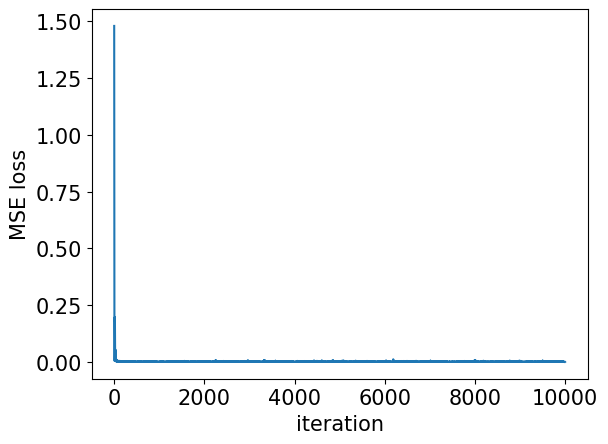

In [73]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')

In [74]:
x = torch.linspace(0, 100, 1000)
y = Data.datagen(x, with_error=False)
y_hat = nn_model(x.unsqueeze(-1)).detach()

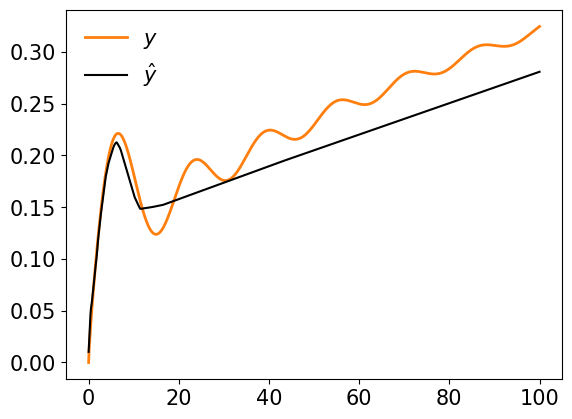

In [75]:
plt.plot(x, y, color='tab:orange', lw=2, label=r'$y$')
plt.plot(x, y_hat, color='k', label=r'$\hat{y}$')
plt.legend(frameon=False)